In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-medium"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Goole has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of devices, and while the iPhone 14 is a great phone, it's not the best phone. The iPhone 14 is a great phone, but it's not the best phone.  The iPhone 14 is
p(answer):  p(' devices'[4410])=0.2049, p(' phones'[9512])=0.1882, p(' smartphones'[18151])=0.1707, p(' hands'[2832])=0.0887, p(' products'[3186])=0.0367

Goole has released Pixel 7
Goole has released Pixel 7 and Pixel 7 Plus, and the Pixel 7 Plus is the most expensive of the two. The Pixel 7 Plus is $649, while the Pixel 7 is $649.  The Pixel 7 is the first phone
p(answer):  p(' and'[290])=0.1817, p(','[11])=0.0804, p('.'[13])=0.0659, p(' Plus'[8227])=0.0247, p(' on'[319])=0.0194

I am taking a Machine Learning class
I am taking a Machine Learning class at the University of California, Berkeley. I am interested in the topic of machine learning and I am looking for a mentor. I am looking for someone who can help me with my research

## Dataset (the `IMDB_50K_Reviews` dataset)

In [5]:
df = pd.read_csv("../Data/IMDB_50K_Reviews/archive/IMDB Dataset.csv")
df = df.sample(frac = 1)
df.head()

,review,sentiment
38747,.... could it be that ITV wouldn't want to rel...,positive
32984,A typical Lanza flick that had limited audienc...,negative
10374,Kurt Thomas stars as Jonathan Cabot some kind ...,negative
32170,"It's a gentle, easy-going 1950s comedy. Kim No...",positive
21268,"As you may have gathered from the title, I who...",negative


In [6]:
for index, row in df.iterrows():
    print(row["review"])
    print(row["sentiment"])
    break

.... could it be that ITV wouldn't want to release this absolute classic because it would show up their current series of Mike Bassett for what it is? When discussing Mike Bassett with some work colleagues I mentioned Bostock's Cup as being a far superior offering and was surprised to find that I seem to be the only person in my entire office that has actually seen it. This can't be right for a film that has got to be the funniest thing I have ever seen.<br /><br />Let's face it, ITV don't have the greatest recent record for producing comedy so you would think that they would jump at the chance of at least repeating something which is genuinely funny. Perhaps if it could be combined with a lucrative telephone competition of where we think the coach driver will go next then they might be interested.<br /><br />Come on ITV, there are still some of us out there who would like to watch original, quality comedy/drama. Do the decent thing thing. Repeat it then get it out on DVD.
positive


In [7]:
train_df = df[0:30000]
validation_df = df[30000:40000]
test_df = df[40000:50000]

In [8]:
train_df.shape, validation_df.shape, test_df.shape

((30000, 2), (10000, 2), (10000, 2))

## Load presaved Data

In [5]:
train_df = pd.read_csv("../Data/IMDB_50K_Reviews/train.csv")
validation_df = pd.read_csv("../Data/IMDB_50K_Reviews/validation.csv")
test_df = pd.read_csv("../Data/IMDB_50K_Reviews/test.csv")

## Dataloader

In [6]:
from torch.utils.data import DataLoader, Dataset

import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("\\", "")
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

# cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

class GoEmotions(Dataset):
    def __init__(self, data_frame):
        self.x = []
        self.y = []

        for index, row in data_frame.iterrows():
            self.x.append("<REVIEW>: " + cleanhtml(row["review"]) + " <SENTIMENT>")
            self.y.append(" " + row["sentiment"])
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [7]:
training_dataset = GoEmotions(train_df)
validation_dataset = GoEmotions(validation_df)
test_dataset = GoEmotions(test_df)

len(training_dataset), len(validation_dataset), len(test_dataset)

(30000, 10000, 10000)

In [8]:
batch_size = 2

training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Adapter Tuning

In [9]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
transformer_blocks = [f"transformer.h.{n}" for n in range(model.config.n_layer)]
mlp_blocks = [f"transformer.h.{n}.mlp" for n in range(model.config.n_layer)]
unembedder = "lm_head"

In [10]:
###############################################################################################################
adapter_dim = 128
hidden_conf = []
num_epochs = 10
###############################################################################################################

learning_rate = 5e-4
warmup_steps = 200
weight_decay = 0

optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Adapter-Tuned_CLF__IMDB_50K/{MODEL_NAME}"

In [11]:
embedder_module = nethook.get_module(model, embedder)
lm_head = nethook.get_module(model, unembedder)

In [12]:
def untuple(output):
    if(type(output) is tuple):
        return output[0]
    return output

def get_shape(output):
    pre = f"{type(output)} ==> "
    if(type(output) is tuple):
        return pre + f"{output[0].shape} -- {(output[1][0].shape, output[1][1].shape)}"
    return pre + f"{output.shape}"

In [13]:
def get_adapter_tuning_edit(adapter_collection):
    def insert_adapters_into_calculation(output, layer, adapter_collection = adapter_collection):
        if(layer not in adapter_collection):
            return output
        # print("intervention ==> ", layer, "output shape ===> ", get_shape(output))

        return adapter_collection[layer](output)
    return insert_adapters_into_calculation

In [14]:
from torch.nn import Linear, ReLU, Sequential, Tanh

def init_weights(m, lo = -0.0001, hi = 0.0001):
    if isinstance(m, Linear):
        torch.nn.init.uniform_(m.weight, a = lo, b = hi)
        torch.nn.init.uniform_(m.bias, a = lo, b = hi)


class Adapter(torch.nn.Module):
    def __init__(self, inp_out_dim, adapter_dim, hidden_conf = []):
        super().__init__()
        self.inp_out_dim = inp_out_dim
        self.conf = [inp_out_dim] + hidden_conf + [adapter_dim] + hidden_conf[::-1] + [inp_out_dim]
        # print(self.conf)
        self.adapter_dim = adapter_dim
        self.layers = []

        i = 1
        while i < len(self.conf):
            inp = self.conf[i-1]
            out = self.conf[i]
            layer_name = f'layer{i}'
            setattr(self, layer_name, Sequential(Linear(inp, out), ReLU()))
            self.layers.append(layer_name)
            i += 1
    
    def forward(self, x):
        x_init = x.clone()
        for module in self.named_children():
            layer_name = module[0]
            layer = getattr(self, layer_name)
            x = layer(x)
        return x + x_init

In [15]:
adapter_blocks = {
    k: Adapter(
        inp_out_dim = model.config.n_embd,
        adapter_dim = adapter_dim,
        hidden_conf = hidden_conf
    ).to(next(model.parameters()).device)
    for k in mlp_blocks
}

for k in adapter_blocks:
    adapter_blocks[k] = adapter_blocks[k].apply(init_weights)

In [16]:
# ## make sure that the effect of adapters are near identity

# prompt = [
#     "Apple has recently released their iPhone 14 line of",
#     "Goole has released Pixel 7",
#     "I am taking a Machine Learning class",
#     "Eiffel Tower is in Paris."
# ]

# txt, ret_dict = model_utils.generate_fast(
#     model, tokenizer,
#     prompt,
#     argmax_greedy = True,
#     max_out_len= 50,
#     get_answer_tokens=True,

#     light_weight_tuning= adapter_blocks, algo = "adapter"
# )

# model_utils.print_formatted_results(prompt, txt, ret_dict)

Epoch 1


  5%|▍         | 718/15000 [01:18<25:56,  9.18it/s]

#####################  CHECKPOINT -- saving weights #####################


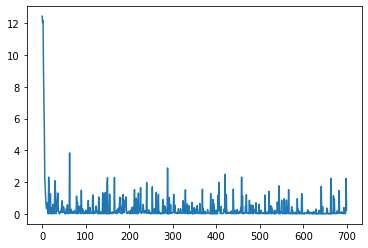

Epoch 2


100%|██████████| 15000/15000 [26:34<00:00,  9.41it/s]


#####################  CHECKPOINT -- saving weights #####################


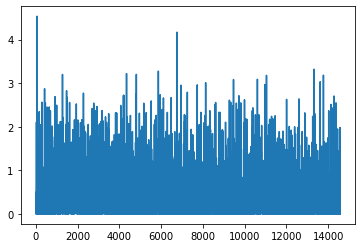

Epoch 3


100%|██████████| 15000/15000 [26:43<00:00,  9.35it/s]


#####################  CHECKPOINT -- saving weights #####################


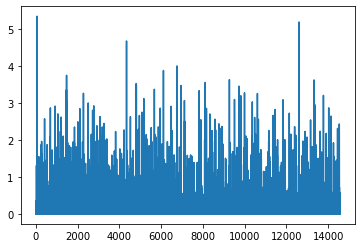

Epoch 4


100%|██████████| 15000/15000 [26:38<00:00,  9.39it/s]


#####################  CHECKPOINT -- saving weights #####################


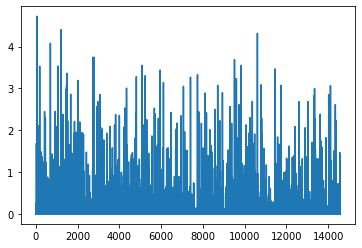

Epoch 5


100%|██████████| 15000/15000 [26:38<00:00,  9.38it/s]


#####################  CHECKPOINT -- saving weights #####################


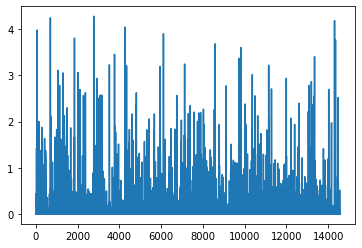

Epoch 6


100%|██████████| 15000/15000 [26:40<00:00,  9.37it/s]


#####################  CHECKPOINT -- saving weights #####################


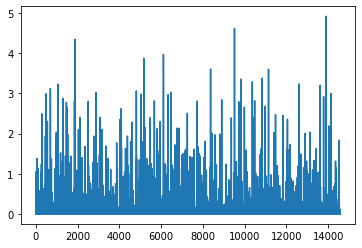

Epoch 7


100%|██████████| 15000/15000 [26:38<00:00,  9.38it/s]


#####################  CHECKPOINT -- saving weights #####################


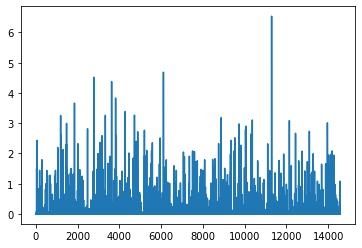

Epoch 8


100%|██████████| 15000/15000 [26:40<00:00,  9.37it/s]


#####################  CHECKPOINT -- saving weights #####################


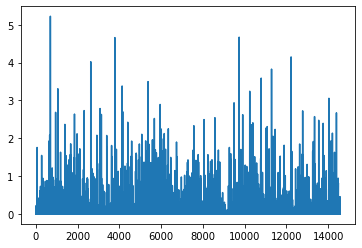

Epoch 9


100%|██████████| 15000/15000 [26:41<00:00,  9.37it/s]


#####################  CHECKPOINT -- saving weights #####################


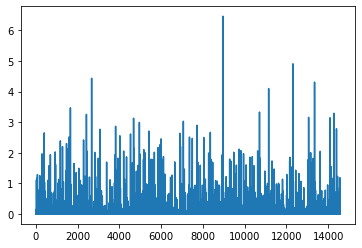

Epoch 10


100%|██████████| 15000/15000 [26:38<00:00,  9.38it/s]


#####################  CHECKPOINT -- saving weights #####################


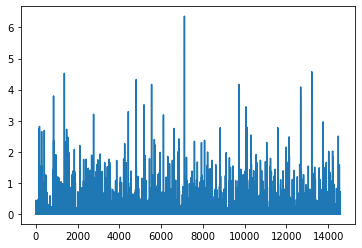

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

# optimizer = AdamW(
#     # model.parameters(),
#     [v for _, v in tunable_weights.items()],
#     lr = learning_rate,
# )
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
# )

# for k in adapter_blocks:
#     adapter_blocks[k].parameters().requires_grad = True

for name, w in model.named_parameters():
    w.requires_grad = True

tunable = []
for k in adapter_blocks:
    tunable += adapter_blocks[k].parameters()

for t in tunable:
    t.requires_grad = True

optimizer = torch.optim.Adam(
    tunable,
    lr=learning_rate,
    weight_decay=weight_decay,
)

num_prompts_optimized = 0
training_loss_track = []
validation_loss_track = []

target_track = {
    " positive": 0,
    " negative": 0
}

###############################################################################
insert_adapter_embeddings = get_adapter_tuning_edit(adapter_blocks)
###############################################################################

limit = 700

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for reviews, sentiments in tqdm(training_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue
            
        for t in sentiments:
            target_track[t] += 1

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        # print(sentiments)

        # print(tokenized_inputs['input_ids'].shape)
        # print(sentiments, target_ids)

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        # tokenized["input_ids"].require_grad = True
        with nethook.TraceDict(
            model,
            [embedder, layer_norm_final] + mlp_blocks + [unembedder],
            edit_output=insert_adapter_embeddings
        ) as traces:
            outputs = model(
                **tokenized_inputs, 
                labels=tokenized_inputs['input_ids']
            )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        training_loss_track.append(loss.item())
        # print(loss)

        model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        limit -= 1
        if(limit == 0):
            break
        
    print("#####################  CHECKPOINT -- saving weights #####################")
    os.makedirs(save_path, exist_ok = True)
    torch.save(adapter_blocks, f"{save_path}/adapter_tuned__epoch_{epoch+1}.pth")
    with open(f"{save_path}/loss_track_{epoch + 1}.json", "w") as f:
        json.dump({"training": training_loss_track, "validation": validation_loss_track}, f)
    
    plt.title("")
    plt.plot(training_loss_track)
    plt.show()
    training_loss_track = []
    # break

## Testing

In [18]:
# checkpoint = torch.load('../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned_0.pth')
# model.load_state_dict(checkpoint)

In [19]:
# ## make sure that the effect of adapters are near identity

# prompt = [
#     "Apple has recently released their iPhone 14 line of",
#     "Goole has released Pixel 7",
#     "I am taking a Machine Learning class",
#     "Eiffel Tower is in Paris."
# ]

# txt, ret_dict = model_utils.generate_fast(
#     model, tokenizer,
#     prompt,
#     argmax_greedy = False,
#     max_out_len= 50,
#     get_answer_tokens=True,

#     light_weight_tuning= adapter_blocks, algo = "adapter"
# )

# model_utils.print_formatted_results(prompt, txt, ret_dict)

In [20]:
prompt = [
    "This was an awesome movie",
    "This was a bad movie",
    "This was not a good movie",
    "That movie was garbage"
]

prompt = ["<REVIEW>: " + p + " <SENTIMENT>" for p in prompt]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 40,
    # debug=True,
    get_answer_tokens=True,

    light_weight_tuning= adapter_blocks, algo = "adapter"
    # track_interesting_words = [
    #     [" positive", " negative"],
    #     [" positive", " negative"]
    # ]
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

<REVIEW>: This was an awesome movie <SENTIMENT>
<REVIEW>: This was an awesome movie <SENTIMENT> a great, great, great, great, great, great, great, great, great, great, great, great,
p(answer):  p(' a'[257])=0.0707, p(' awesome'[7427])=0.0662, p(' the'[262])=0.0515, p(' positive'[3967])=0.05, p(' great'[1049])=0.0478

<REVIEW>: This was a bad movie <SENTIMENT>
<REVIEW>: This was a bad movie <SENTIMENT> negative.  The film is a negative.  The film is a negative.  The film is a negative
p(answer):  p(' negative'[4633])=0.2896, p(' bad'[2089])=0.2497, p(' not'[407])=0.0727, p(' a'[257])=0.0264, p(' the'[262])=0.0151

<REVIEW>: This was not a good movie <SENTIMENT>
<REVIEW>: This was not a good movie <SENTIMENT> negative.  The film is a "sad" and "sad-looking" film.  The
p(answer):  p(' negative'[4633])=0.2641, p(' bad'[2089])=0.069, p(' not'[407])=0.0563, p(' a'[257])=0.0213, p(' the'[262])=0.0202

<REVIEW>: That movie was garbage <SENTIMENT>
<REVIEW>: That movie was garbage <SENTIMENT> ne

In [21]:
testing_dataloader = DataLoader(test_dataset, batch_size=1)

target = []
predict = []Saved_weights/Adapter-Tuned_CLF__IMDB_50K/gpt2-medium/adapter_tuned__epoch_3.pth

for reviews, sentiment in tqdm(testing_dataloader):
    tokenized_inputs = tokenizer(
        list(reviews),
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
        # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
        continue

    last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1)
    max_out_len = max(last_token_inds).item()

    with torch.no_grad():
        txt, ret_dict = model_utils.generate_fast(
            model, tokenizer,
            list(reviews),
            argmax_greedy = True,
            max_out_len= max_out_len + 3,
            # debug=True,
            get_answer_tokens=True,

            light_weight_tuning= adapter_blocks, algo = "adapter"
        )

    for t, p in zip(list(sentiment), ret_dict['answer']):
        target.append(t)
        predict.append(p['top_token'])

    # print(txt, ret_dict['answer'])

    # break

100%|██████████| 10000/10000 [07:53<00:00, 21.10it/s]


In [22]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(target, predict).ravel()

print(tp, fp)
print(fn, tn)

4830 536
165 4307


In [23]:
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
balanced_acc = (sensitivity + specificity)/2

balanced_acc

0.928145882822736

In [25]:
target_track

{' positive': 130937, ' negative': 132777}

In [27]:
torch.save(adapter_blocks)

{'transformer.h.0.mlp': Adapter(
   (layer1): Sequential(
     (0): Linear(in_features=1024, out_features=128, bias=True)
     (1): ReLU()
   )
   (layer2): Sequential(
     (0): Linear(in_features=128, out_features=1024, bias=True)
     (1): ReLU()
   )
 ),
 'transformer.h.1.mlp': Adapter(
   (layer1): Sequential(
     (0): Linear(in_features=1024, out_features=128, bias=True)
     (1): ReLU()
   )
   (layer2): Sequential(
     (0): Linear(in_features=128, out_features=1024, bias=True)
     (1): ReLU()
   )
 ),
 'transformer.h.2.mlp': Adapter(
   (layer1): Sequential(
     (0): Linear(in_features=1024, out_features=128, bias=True)
     (1): ReLU()
   )
   (layer2): Sequential(
     (0): Linear(in_features=128, out_features=1024, bias=True)
     (1): ReLU()
   )
 ),
 'transformer.h.3.mlp': Adapter(
   (layer1): Sequential(
     (0): Linear(in_features=1024, out_features=128, bias=True)
     (1): ReLU()
   )
   (layer2): Sequential(
     (0): Linear(in_features=128, out_features=1024, b